In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

In [9]:
Measurement.__dict__

mappingproxy({'__table__': Table('measurement', MetaData(), Column('id', INTEGER(), table=<measurement>, primary_key=True, nullable=False), Column('station', TEXT(), table=<measurement>), Column('date', TEXT(), table=<measurement>), Column('prcp', FLOAT(), table=<measurement>), Column('tobs', FLOAT(), table=<measurement>), schema=None),
              '__module__': 'sqlalchemy.ext.automap',
              '__doc__': None,
              '_sa_class_manager': <ClassManager of <class 'sqlalchemy.ext.automap.measurement'> at 24c19c0f7e0>,
              '__init__': <function sqlalchemy.orm.instrumentation.__init__(self, **kwargs)>,
              'id': <sqlalchemy.orm.attributes.InstrumentedAttribute at 0x24c19ff1ad0>,
              'station': <sqlalchemy.orm.attributes.InstrumentedAttribute at 0x24c1a028680>,
              'date': <sqlalchemy.orm.attributes.InstrumentedAttribute at 0x24c1a028720>,
              'prcp': <sqlalchemy.orm.attributes.InstrumentedAttribute at 0x24c1a0287c0>,
       

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
str_date = session.query(func.max(Measurement.date)).scalar()
str_date

'2017-08-23'

Text(0, 0.5, 'Inches')

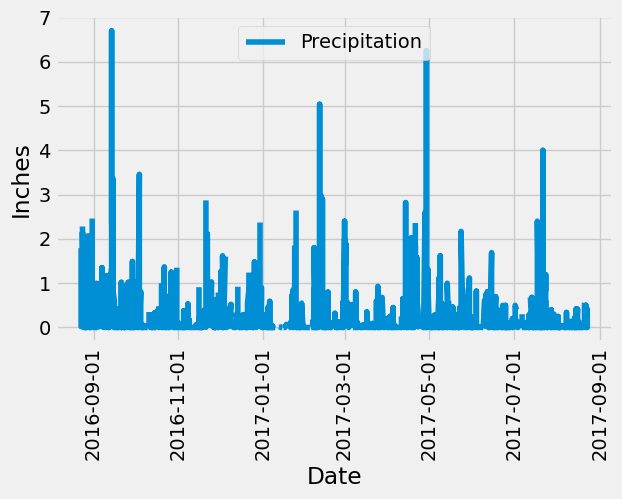

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.
recent_date = dt.date(*map(int, str_date.split('-')))

# Calculate the date one year from the last date in data set.
one_year_ago = dt.date(recent_date.year - 1, recent_date.month, recent_date.day)

# Perform a query to retrieve the data and precipitation scores
result = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(result, columns=["Date", "Precipitation"])

# Sort the dataframe by date
df = df.sort_values(by="Date").reset_index(drop=True)
df["Date"] = df["Date"].astype("datetime64")

# Use Pandas Plotting with Matplotlib to plot the data
ax = df.plot.line("Date", "Precipitation", legend=False)
import matplotlib.dates as md
ax.xaxis.set_major_formatter(md.DateFormatter("%Y-%m-%d"))
del md
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=90, horizontalalignment='center')

plt.legend(loc='upper center')
plt.ylabel("Inches")

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
Station.__dict__

mappingproxy({'__table__': Table('station', MetaData(), Column('id', INTEGER(), table=<station>, primary_key=True, nullable=False), Column('station', TEXT(), table=<station>), Column('name', TEXT(), table=<station>), Column('latitude', FLOAT(), table=<station>), Column('longitude', FLOAT(), table=<station>), Column('elevation', FLOAT(), table=<station>), schema=None),
              '__module__': 'sqlalchemy.ext.automap',
              '__doc__': None,
              '_sa_class_manager': <ClassManager of <class 'sqlalchemy.ext.automap.station'> at 24c19ff1ee0>,
              '__init__': <function sqlalchemy.orm.instrumentation.__init__(self, **kwargs)>,
              'id': <sqlalchemy.orm.attributes.InstrumentedAttribute at 0x24c1a028b30>,
              'station': <sqlalchemy.orm.attributes.InstrumentedAttribute at 0x24c1a028b80>,
              'name': <sqlalchemy.orm.attributes.InstrumentedAttribute at 0x24c1a028c20>,
              'latitude': <sqlalchemy.orm.attributes.InstrumentedAttr

In [14]:
# Design a query to calculate the total number of stations in the dataset
session.query(Station).count()

9

In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
session.query(Station.station, func.count(Measurement.station)).join(Measurement, Measurement.station == Station.station).group_by(Station.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

Text(0.5, 0, 'Temperature')

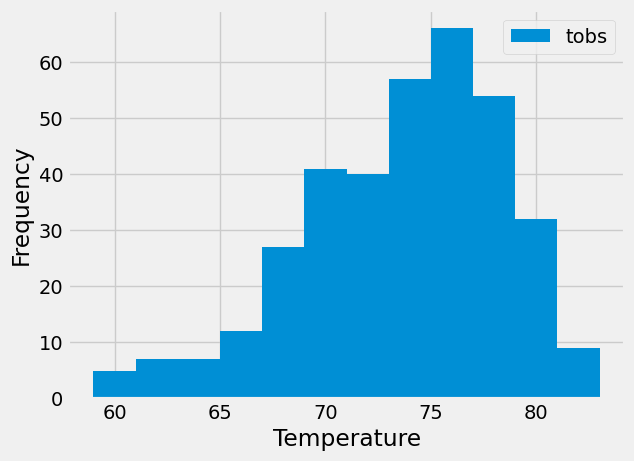

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
recent_date_most_active = dt.date(*map(int, session.query(func.max(Measurement.date)).filter(Measurement.station == 'USC00519281').scalar().split("-")))
one_year_ago_most_active = dt.date(recent_date_most_active.year - 1, recent_date_most_active.month, recent_date_most_active.day)
result = session.query(Measurement.tobs).filter(Measurement.station == 'USC00519281').filter(Measurement.date >= one_year_ago_most_active).all()
df = pd.DataFrame(result, columns=["tobs"])
df.plot.hist(bins=12)
plt.xlabel("Temperature")

# Close Session

In [18]:
# Close Session
session.close()